In [1]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import to_categorical
import cv2, numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import applications
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import xml.etree.cElementTree as ET
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from shutil import copyfile
from pathlib import Path
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#df = pd.read_csv("/data/web/PlantCLEF2017TrainWeb.csv",delimiter=';')
#df.head(10)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16827538193430015040
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 12113123321127893734
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [2]:
df.shape

(1442641, 11)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df['ClassId'],
                                                    stratify=df['ClassId'],
                                                    random_state=123,
                                                    test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, X_train['ClassId'],
                                                    stratify=X_train['ClassId'],
                                                    random_state=123,
                                                    test_size=0.3)
print(len(Counter(df.ClassId)))
print(len(Counter(df.ObservationId)))
X_train.head(10)

10000
1442641


,Species,Origin,OriginalUrl,Genus,Family,ObservationId,MediaId,YearInCLEF,LearnTag,ClassId,BackUpLink
270692,Haberlea rhodopensis Friv.,web,http://media.eol.org/content/2012/05/23/14/734...,Haberlea,Gesneriaceae,1378302,1452659,PlantCLEF2017,Train,140196,http://otmedia.lirmm.fr/LifeCLEF/b/w/140196/14...
1106300,Carex rosea Willd.,web,http://upload.wikimedia.org/wikipedia/commons/...,Carex,Cyperaceae,763008,837365,PlantCLEF2017,Train,112504,http://otmedia.lirmm.fr/LifeCLEF/b/w/112504/83...
134790,Juncus triglumis L.,web,http://media.eol.org/content/2012/03/07/07/825...,Juncus,Juncaceae,1544038,1618395,PlantCLEF2017,Train,147824,http://otmedia.lirmm.fr/LifeCLEF/b/w/147824/16...
744365,Asclepias quadrifolia Jacq.,web,http://lucasland.org/wildflowers/m/images/four...,Asclepias,Asclepiadaceae,555292,629649,PlantCLEF2017,Train,19599,http://otmedia.lirmm.fr/LifeCLEF/b/w/19599/629...
196291,Leucojum vernum L.,web,http://media.eol.org/content/2012/05/23/17/375...,Leucojum,Liliaceae,1617548,1691905,PlantCLEF2017,Train,11512,http://otmedia.lirmm.fr/LifeCLEF/b/w/11512/169...
623244,Pachyrhizus erosus (L.) Urb.,web,http://thumb1.shutterstock.com/display_pic_wit...,Pachyrhizus,Fabaceae,1910322,1984679,PlantCLEF2017,Train,179413,http://otmedia.lirmm.fr/LifeCLEF/b/w/179413/19...
1044567,Hibiscadelphus giffardianus Rock,web,https://tse2.mm.bing.net/th?id=OIP.M3f020274de...,Hibiscadelphus,Malvaceae,1423932,1498289,PlantCLEF2017,Train,193843,http://otmedia.lirmm.fr/LifeCLEF/b/w/193843/14...
139202,Schoenoplectus pungens (Vahl) Palla,web,http://media.eol.org/content/2016/07/22/17/982...,Schoenoplectus,Cyperaceae,2367736,2442093,PlantCLEF2017,Train,115784,http://otmedia.lirmm.fr/LifeCLEF/b/w/115784/24...
1175119,Gymnocalycium ochoterenae Backeb.,web,http://cludwigfr.dyndns.org/images/gallery/Gym...,Gymnocalycium,Cactaceae,1374982,1449339,PlantCLEF2017,Train,55683,http://otmedia.lirmm.fr/LifeCLEF/b/w/55683/144...
238290,Melastoma sanguineum Sims,web,http://media.eol.org/content/2016/08/03/05/249...,Melastoma,Melastomataceae,1753967,1828324,PlantCLEF2017,Train,199379,http://otmedia.lirmm.fr/LifeCLEF/b/w/199379/18...


In [5]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(807878, 11)
(346234, 11)
(288529, 11)


# Copie des images en /training /validation /test

In [4]:
FileName = []
FinalDir = []
for index, row in X_train.iterrows():
    file_path = '/data/web/data/' + str(row['ClassId']) + '/' + str(row['MediaId']) + '.jpg'
    FileName.append(file_path)
    target_dir = '/data/Training/' + str(row['ClassId']) + '/' + str(row['MediaId']) + '.jpg'
    FinalDir.append(target_dir)
    if not os.path.exists(os.path.dirname(target_dir)):
        try:
            os.makedirs(os.path.dirname(target_dir))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    try:
        copyfile(file_path, target_dir)
    except:
        next
X_train = X_train.assign(FileName=pd.Series(FileName).values)
X_train = X_train.assign(FinalDir=pd.Series(FinalDir).values)

FileName = []
FinalDir = []
for index, row in X_validation.iterrows():
    file_path = '/data/web/data/' + str(row['ClassId']) + '/' + str(row['MediaId']) + '.jpg'
    FileName.append(file_path)
    target_dir = '/data/Validation/' + str(row['ClassId']) + '/' + str(row['MediaId']) + '.jpg'
    FinalDir.append(target_dir)
    if not os.path.exists(os.path.dirname(target_dir)):
        try:
            os.makedirs(os.path.dirname(target_dir))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    try:
        copyfile(file_path, target_dir)
    except:
        next
X_validation = X_validation.assign(FileName=pd.Series(FileName).values)
X_validation = X_validation.assign(FinalDir=pd.Series(FinalDir).values)

FileName = []
FinalDir = []
for index, row in X_test.iterrows():
    file_path = '/data/web/data/' + str(row['ClassId']) + '/' + str(row['MediaId']) + '.jpg'
    FileName.append(file_path)
    target_dir = '/data/Test/' + str(row['ClassId']) + '/' + str(row['MediaId']) + '.jpg'
    FinalDir.append(target_dir)
    if not os.path.exists(os.path.dirname(target_dir)):
        try:
            os.makedirs(os.path.dirname(target_dir))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    try:
        copyfile(file_path, target_dir)
    except:
        next
X_test = X_test.assign(FileName=pd.Series(FileName).values)
X_test = X_test.assign(FinalDir=pd.Series(FinalDir).values)

X_train.to_csv("/data/training.csv",index=False)
X_validation.to_csv("/data/validation.csv",index=False)
X_test.to_csv("/data/test.csv",index=False)

In [35]:
X_train = pd.read_csv('/data/training.csv')
X_validation = pd.read_csv('/data/validation.csv')
X_test = pd.read_csv('/data/test.csv')
print(X_train.shape)
print(y_train.size)
print(X_validation.shape)
print(y_validation.size)
print(X_test.shape)
print(y_test.size)

(807878, 13)
807878
(346234, 13)
346234
(288529, 13)
288529


In [36]:
X_train.head(10)

,Species,Origin,OriginalUrl,Genus,Family,ObservationId,MediaId,YearInCLEF,LearnTag,ClassId,BackUpLink,FileName,FinalDir
0,Haberlea rhodopensis Friv.,web,http://media.eol.org/content/2012/05/23/14/734...,Haberlea,Gesneriaceae,1378302,1452659,PlantCLEF2017,Train,140196,http://otmedia.lirmm.fr/LifeCLEF/b/w/140196/14...,/data/web/data/140196/1452659.jpg,/data/Training/140196/1452659.jpg
1,Carex rosea Willd.,web,http://upload.wikimedia.org/wikipedia/commons/...,Carex,Cyperaceae,763008,837365,PlantCLEF2017,Train,112504,http://otmedia.lirmm.fr/LifeCLEF/b/w/112504/83...,/data/web/data/112504/837365.jpg,/data/Training/112504/837365.jpg
2,Juncus triglumis L.,web,http://media.eol.org/content/2012/03/07/07/825...,Juncus,Juncaceae,1544038,1618395,PlantCLEF2017,Train,147824,http://otmedia.lirmm.fr/LifeCLEF/b/w/147824/16...,/data/web/data/147824/1618395.jpg,/data/Training/147824/1618395.jpg
3,Asclepias quadrifolia Jacq.,web,http://lucasland.org/wildflowers/m/images/four...,Asclepias,Asclepiadaceae,555292,629649,PlantCLEF2017,Train,19599,http://otmedia.lirmm.fr/LifeCLEF/b/w/19599/629...,/data/web/data/19599/629649.jpg,/data/Training/19599/629649.jpg
4,Leucojum vernum L.,web,http://media.eol.org/content/2012/05/23/17/375...,Leucojum,Liliaceae,1617548,1691905,PlantCLEF2017,Train,11512,http://otmedia.lirmm.fr/LifeCLEF/b/w/11512/169...,/data/web/data/11512/1691905.jpg,/data/Training/11512/1691905.jpg
5,Pachyrhizus erosus (L.) Urb.,web,http://thumb1.shutterstock.com/display_pic_wit...,Pachyrhizus,Fabaceae,1910322,1984679,PlantCLEF2017,Train,179413,http://otmedia.lirmm.fr/LifeCLEF/b/w/179413/19...,/data/web/data/179413/1984679.jpg,/data/Training/179413/1984679.jpg
6,Hibiscadelphus giffardianus Rock,web,https://tse2.mm.bing.net/th?id=OIP.M3f020274de...,Hibiscadelphus,Malvaceae,1423932,1498289,PlantCLEF2017,Train,193843,http://otmedia.lirmm.fr/LifeCLEF/b/w/193843/14...,/data/web/data/193843/1498289.jpg,/data/Training/193843/1498289.jpg
7,Schoenoplectus pungens (Vahl) Palla,web,http://media.eol.org/content/2016/07/22/17/982...,Schoenoplectus,Cyperaceae,2367736,2442093,PlantCLEF2017,Train,115784,http://otmedia.lirmm.fr/LifeCLEF/b/w/115784/24...,/data/web/data/115784/2442093.jpg,/data/Training/115784/2442093.jpg
8,Gymnocalycium ochoterenae Backeb.,web,http://cludwigfr.dyndns.org/images/gallery/Gym...,Gymnocalycium,Cactaceae,1374982,1449339,PlantCLEF2017,Train,55683,http://otmedia.lirmm.fr/LifeCLEF/b/w/55683/144...,/data/web/data/55683/1449339.jpg,/data/Training/55683/1449339.jpg
9,Melastoma sanguineum Sims,web,http://media.eol.org/content/2016/08/03/05/249...,Melastoma,Melastomataceae,1753967,1828324,PlantCLEF2017,Train,199379,http://otmedia.lirmm.fr/LifeCLEF/b/w/199379/18...,/data/web/data/199379/1828324.jpg,/data/Training/199379/1828324.jpg


# Nettoyage des images corrompues

In [4]:
for root, dirs, files in os.walk('/data/Training'):
    for name in files:
        try:
            Image.open(root + '/' + name)
        except IOError:
            os.remove(root + '/' + name)
            print('removed: ' + root + '/' + name)

for root, dirs, files in os.walk('/data/Validation'):
    for name in files:
        try:
            Image.open(root + '/' + name)
        except IOError:
            os.remove(root + '/' + name)
            print('removed: ' + root + '/' + name)

for root, dirs, files in os.walk('/data/Test'):
    for name in files:
        try:
            Image.open(root + '/' + name)
        except IOError:
            os.remove(root + '/' + name)
            print('removed: ' + root + '/' + name)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 8274. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262401 bytes but only got 8277. Skipping tag 35868
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16515072 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 17039360 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, le

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19988480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262144000 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:569: UserWarning: Metadata Warning, tag 296 had too many entries: 2, expected 1
  tag, len(values)))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288000 bytes but only got 0. Skipping tag 52
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:72

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 5972. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 99877888 bytes but only got 0. Skipping tag 1029
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20054016 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 5364. Skipping tag 24576
  " Skipping tag %s" % (size, le

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 566099968 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 568721408 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 569245696 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(d

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 7616. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262401 bytes but only got 7619. Skipping tag 17217
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 23920640 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 7620. Skipping tag 3
  " Skipping tag %s" % (size, le

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2621440000 bytes but only got 0. Skipping tag 53
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 112459776 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 692256768 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1441814 bytes but only got 9366. Skipping tag 14
  " Skipping tag %s" % (size, l

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 10288. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26764827456 bytes but only got 0. Skipping tag 58220
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7616905278 bytes but only got 0. Skipping tag 10168
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 9. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs

In [41]:
idx_wrong = []
for index, file_path in enumerate(X_train.FinalDir):
    my_file = Path(file_path)
    if my_file.is_file():
        statinfo = os.path.getsize(file_path)
        if statinfo < 1000:
            idx_wrong.append(index)
    else:
        idx_wrong.append(index)
X_train = X_train.drop(X_train.index[idx_wrong])

idx_wrong = []
for index, file_path in enumerate(X_validation.FinalDir):
    my_file = Path(file_path)
    if my_file.is_file():
        statinfo = os.path.getsize(file_path)
        if statinfo < 1000:
            idx_wrong.append(index)
    else:
        idx_wrong.append(index)
X_validation = X_validation.drop(X_validation.index[idx_wrong])

idx_wrong = []
for index, file_path in enumerate(X_test.FinalDir):
    my_file = Path(file_path)
    if my_file.is_file():
        statinfo = os.path.getsize(file_path)
        if statinfo < 1000:
            idx_wrong.append(index)
    else:
        idx_wrong.append(index)
X_test = X_test.drop(X_test.index[idx_wrong])

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(802028, 13)
(343712, 13)
(286418, 13)


# Test VGG16

In [144]:
img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

batch_size = 32
epochs = 50

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validation, y_validation),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

predictions = model.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

InvalidArgumentError: Received a label value of 268134 which is outside the valid range of [0, 1).  Label values: 7870 194306 268134 268134 194306 268134 7870 268134 194306 194306 194306 268134 268134 194306 7870 7870 194306 268134 7870 268134 7870 7870 194306 194306 7870 7870 194306 268134 194306 194306 268134 7870
	 [[Node: loss_12/sequential_9_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](loss_12/sequential_9_loss/Reshape_1, loss_12/sequential_9_loss/Cast)]]

Caused by op 'loss_12/sequential_9_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "C:\Users\axel3\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\axel3\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\axel3\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\axel3\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\axel3\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\axel3\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-144-9bcf481eec33>", line 12, in <module>
    metrics=['accuracy'])
  File "C:\Users\axel3\Anaconda3\lib\site-packages\keras\engine\training.py", line 827, in compile
    sample_weight, mask)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\keras\engine\training.py", line 426, in weighted
    score_array = fn(y_true, y_pred)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\keras\losses.py", line 73, in sparse_categorical_crossentropy
    return K.sparse_categorical_crossentropy(y_true, y_pred)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3038, in sparse_categorical_crossentropy
    logits=logits)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1879, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 4546, in _sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\axel3\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of 268134 which is outside the valid range of [0, 1).  Label values: 7870 194306 268134 268134 194306 268134 7870 268134 194306 194306 194306 268134 268134 194306 7870 7870 194306 268134 7870 268134 7870 7870 194306 194306 7870 7870 194306 268134 194306 194306 268134 7870
	 [[Node: loss_12/sequential_9_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](loss_12/sequential_9_loss/Reshape_1, loss_12/sequential_9_loss/Cast)]]


In [152]:
predictions[0][0]

<tf.Tensor 'strided_slice_7:0' shape=() dtype=float32>

# Test Xception

In [2]:
nbClasses = 100

img_rows, img_cols, img_channel = 299, 299, 3
base_model = applications.xception.Xception(weights='imagenet', include_top=False, input_shape=None)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 10 000 classes
predictions = Dense(nbClasses, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=SGD(lr=0.0002,momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)
    
#model.summary()

data_path = '/data/test_5classes/'

batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_path + 'Training/',  
    target_size=(299,299),  
    batch_size=batch_size)  


validation_generator = validation_datagen.flow_from_directory(
        data_path + 'Validation/',
        target_size=(299,299),
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        data_path + 'Test/',
        target_size=(299,299),
        batch_size=batch_size)

history_classif = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[ModelCheckpoint(data_path + 'Xception-transferlearning.model', monitor='val_acc', save_best_only=True)]
)
#model.save_weights(data_path + 'weights/first_try.h5')

# we chose to train the top 2 Xception blocks, i.e. we will freeze
# the first 115 layers and unfreeze the rest:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

#model.summary()

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_conv1 = model.fit_generator(
    train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    epochs=5,
    validation_data=test_generator,
    callbacks=[ModelCheckpoint('/data/Xception-transferlearning2.model', monitor='val_acc', save_best_only=True)]
)

model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_conv2 = model.fit_generator(
    train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    epochs=5,
    validation_data=test_generator,
    callbacks=[ModelCheckpoint('/data/Xception-transferlearning2.model', monitor='val_acc', save_best_only=True)]
)

Found 8870 images belonging to 100 classes.
Found 2658 images belonging to 100 classes.
Found 2221 images belonging to 100 classes.
Epoch 1/10
277/277 [==============================] - 225s 813ms/step - loss: 5.2900 - acc: 0.0446 - val_loss: 4.1741 - val_acc: 0.1441
Epoch 2/10
277/277 [==============================] - 222s 803ms/step - loss: 4.2423 - acc: 0.1385 - val_loss: 3.6197 - val_acc: 0.2035
Epoch 3/10
277/277 [==============================] - 222s 803ms/step - loss: 3.8257 - acc: 0.1899 - val_loss: 3.4697 - val_acc: 0.2350
Epoch 4/10
277/277 [==============================] - 222s 802ms/step - loss: 3.5884 - acc: 0.2261 - val_loss: 3.3488 - val_acc: 0.2643
Epoch 5/10
277/277 [==============================] - 223s 804ms/step - loss: 3.3945 - acc: 0.2485 - val_loss: 3.2500 - val_acc: 0.2828
Epoch 6/10
277/277 [==============================] - 222s 803ms/step - loss: 3.2513 - acc: 0.2762 - val_loss: 3.1834 - val_acc: 0.2985
Epoch 7/10
277/277 [==============================] 

In [3]:
test_loss, test_acc = model.evaluate_generator(test_generator)
print(test_acc)
model.save_weights('/data/weights/Xception_100classes_web.h5')

0.357046375547


In [14]:
tab_pred = model.predict_generator(test_generator)
print(tab_pred)

[[ 0.02283126  0.11316296  0.68044007  0.0240187   0.15954697]
 [ 0.04511739  0.10570345  0.35347193  0.03164473  0.46406248]
 [ 0.02370829  0.08139575  0.07338186  0.02153399  0.7999801 ]
 [ 0.01247473  0.17789245  0.37684703  0.06550358  0.36728218]
 [ 0.10582628  0.204217    0.20923574  0.08897622  0.39174479]
 [ 0.00560033  0.01005423  0.00583122  0.00362674  0.97488743]
 [ 0.01136653  0.10116598  0.06943285  0.01145761  0.80657709]
 [ 0.14569692  0.08396563  0.16824833  0.02070954  0.58137959]
 [ 0.03031346  0.26746431  0.49287051  0.09588657  0.11346512]
 [ 0.21255271  0.31931135  0.11447274  0.08292494  0.27073827]
 [ 0.06145135  0.3151471   0.25831273  0.12091254  0.24417628]
 [ 0.06738333  0.70865166  0.11259052  0.01910483  0.09226964]
 [ 0.06426339  0.38910243  0.22605535  0.14688522  0.17369361]
 [ 0.09455742  0.06476377  0.32095408  0.0076036   0.51212114]
 [ 0.01361222  0.09335718  0.14401869  0.015232    0.73377985]
 [ 0.04920722  0.14273587  0.09898313  0.02468804  0.68

In [14]:
model_vgg16 = applications.VGG16(input_shape=(224, 224, 3),include_top=False)
add_model = Sequential()
add_model.add(Flatten(input_shape=model_vgg16.output_shape[1:]))
add_model.add(BatchNormalization())
add_model.add(Dense(512, activation='relu'))
add_model.add(BatchNormalization())
#add_model.add(Dropout(0.5))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dense(nbClasses, activation='softmax'))

model_vgg16 = Model(inputs=model_vgg16.input, outputs=add_model(model_vgg16.output))
model_vgg16.load_weights('/data/weights/vgg16_100classes_web.h5')
model_xception = model

In [22]:
import operator

classes_dico = train_generator.class_indices
classes_dico = {classes_dico[i]:i for i in classes_dico}
path = '/data/test_5classes/Test'
n_first = 5

def prediction(path, model, classes, n_first=len(path)):
    im = cv2.resize(cv2.imread(path), (224, 224)).astype(np.float32)
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((1,0,2))
    im = np.expand_dims(im, axis=0)
    out = model.predict(im)
    b = {classes[i]: out[0][i] for i in range(len(out[0]))}
    b = sorted(b.items(), key=operator.itemgetter(1), reverse = True)
    b = b[:n_first]
    return b

def parcours(path, model , classes):
    _list = os.listdir(path)
    pred = dict()
    for _dir in _list:
        for elt in os.listdir(path+"/"+_dir):
            image_name = elt[:elt.rfind(".")] 
            #pred[image_name] = prediction(path+"/"+_dir+"/"+elt, model, classes, n_first)
            try:
                pred[image_name] = prediction(path+"/"+_dir+"/"+elt, model, classes, n_first)
            except:
                print ("erreur avec l'image "+path+"/"+_dir+"/"+elt)
    return pred

vgg16_dico = parcours(path, model_vgg16 , classes_dico)
xception_dico = parcours(path, model_xception , classes_dico)

erreur avec l'image /data/test_5classes/Test/331575/2843285.jpg
erreur avec l'image /data/test_5classes/Test/331586/2846246.jpg
erreur avec l'image /data/test_5classes/Test/331519/2842198.jpg
erreur avec l'image /data/test_5classes/Test/330570/1076990.jpg
erreur avec l'image /data/test_5classes/Test/330590/1077290.jpg
erreur avec l'image /data/test_5classes/Test/331175/2287656.jpg
erreur avec l'image /data/test_5classes/Test/331175/2287566.jpg
erreur avec l'image /data/test_5classes/Test/331175/2287736.jpg
erreur avec l'image /data/test_5classes/Test/331583/2099905.jpg
erreur avec l'image /data/test_5classes/Test/331583/2099781.jpg
erreur avec l'image /data/test_5classes/Test/331597/2846548.jpg
erreur avec l'image /data/test_5classes/Test/331705/1656989.jpg
erreur avec l'image /data/test_5classes/Test/330601/1077652.jpg
erreur avec l'image /data/test_5classes/Test/331599/2846847.jpg
erreur avec l'image /data/test_5classes/Test/331599/2846812.jpg
erreur avec l'image /data/test_5classes/

In [33]:
from math import log
import csv
info = '/data/test.csv'

def agrege(dico,tab):
    for rang in range(len(tab)):
        classes = tab[rang][0]
        if tab[rang][1] == 0:
            proba = 1e-32
        elif tab[rang][1] == 1:
            proba = 0.9
        else:
            proba = tab[rang][1]
        val = -1.0/((rang+1.0)*log(proba))
        if classes in dico:
            dico[classes] = dico[classes]+val
        else:
            dico[classes] = val
    return dico

def id_to_name (path):
    """
    Crée un dictionnaire ayant pour index le nom de l'image sans l'extension et le nom de l'espèce
    """
    dico = dict()
    with open(path, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        header = True
        for row in spamreader:
            if header:
                header = not header
                index = row.index("ClassId")
                Species = row.index("Species")
                Genus = row.index("Genus")
                Family = row.index("Family")
            else:
                dico[row[index]] = row[Family]+"-"+row[Genus]+"-"+row[Species]
    return dico

def id_to_name2 (path):
    """
    Crée un dictionnaire ayant pour index le nom de l'image sans l'extension et le nom de l'espèce
    """
    dico = dict()
    with open(path, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        header = True
        for row in spamreader:
            if header:
                header = not header
                index = row.index("MediaId")
                Species = row.index("Species")
                Genus = row.index("Genus")
                Family = row.index("Family")
            else:
                dico[row[index]] = row[Family]+"-"+row[Genus]+"-"+row[Species]
    return dico

def scrutin(dico, *pred):
    pred = list(pred)
    vote = dict()
    if (len(pred) > 1):
        first = pred.pop(0)
        for i in first:
            tmp = agrege(dict(),first[i])
            for j in pred:
                tmp = agrege(tmp,j[i])
            vote[i] = dico[sorted(tmp.items(), key=operator.itemgetter(1), reverse=True)[0][0]]
    return vote
dico = id_to_name(info)
decision = scrutin(dico,vgg16_dico,xception_dico)
dico2 = id_to_name2(info)

total = 0
family = 0
genre = 0
espece = 0

for i in decision:
    total = total+1
    tab1 = dico2[i].split("-")
    tab2 = decision[i].split("-")
    if (tab1[0] == tab2[0]):
        family = family+1
    if (tab1[1] == tab2[1]):
        genre = genre+1
    if (tab1[2] == tab2[2]):
        espece = espece+1
print("Taux de juste pour la famille : "+str(family*1.0/total))
print("Taux de juste pour le genre : "+str(genre*1.0/total))
print("Taux de juste pour l'espèce : "+str(espece*1.0/total))


Taux de juste pour la famille : 0.7683923705722071
Taux de juste pour le genre : 0.1784741144414169
Taux de juste pour l'espèce : 0.05676657584014532


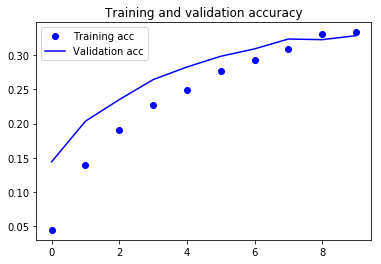

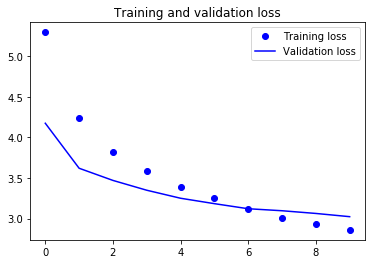

In [5]:
import matplotlib.pyplot as plt

acc = history_classif.history ['acc']
val_acc = history_classif.history['val_acc']
loss = history_classif.history['loss']
val_loss = history_classif.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

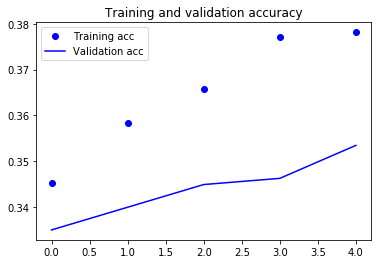

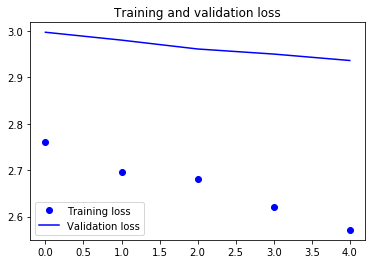

In [6]:
import matplotlib.pyplot as plt

acc = history_conv1.history ['acc']
val_acc = history_conv1.history['val_acc']
loss = history_conv1.history['loss']
val_loss = history_conv1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

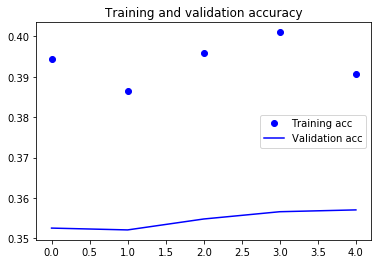

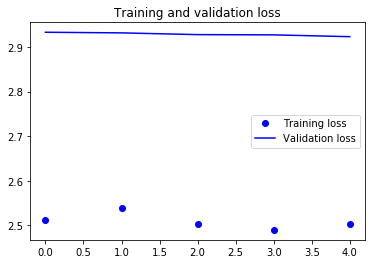

In [7]:
import matplotlib.pyplot as plt

acc = history_conv2.history ['acc']
val_acc = history_conv2.history['val_acc']
loss = history_conv2.history['loss']
val_loss = history_conv2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [100]:
data_path = '/data/test_5classes/'

batch_size = 8
epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_path + 'Training/',  
    target_size=(299,299),  
    batch_size=batch_size)  


validation_generator = test_datagen.flow_from_directory(
        data_path + 'Validation/',
        target_size=(299,299),
        batch_size=batch_size)

model.fit_generator(
    train_generator,
    steps_per_epoch = 299 // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint(data_path + 'Xception-transferlearning.model', monitor='val_acc', save_best_only=True)]
)
#model.save_weights(data_path + 'weights/first_try.h5')

Found 299 images belonging to 5 classes.
Found 129 images belonging to 5 classes.
Epoch 1/10
37/37 [==============================] - 46s 1s/step - loss: 10.0266 - acc: 0.3536 - val_loss: 9.8494 - val_acc: 0.3798
Epoch 2/10
37/37 [==============================] - 10s 264ms/step - loss: 9.8738 - acc: 0.3874 - val_loss: 9.8401 - val_acc: 0.3798
Epoch 3/10
37/37 [==============================] - 10s 260ms/step - loss: 10.2890 - acc: 0.3616 - val_loss: 9.8754 - val_acc: 0.3798
Epoch 4/10
37/37 [==============================] - 10s 265ms/step - loss: 10.0194 - acc: 0.3784 - val_loss: 9.9104 - val_acc: 0.3798
Epoch 5/10
37/37 [==============================] - 9s 256ms/step - loss: 9.9460 - acc: 0.3829 - val_loss: 9.9308 - val_acc: 0.3798
Epoch 6/10
37/37 [==============================] - 10s 264ms/step - loss: 9.9649 - acc: 0.3818 - val_loss: 9.9560 - val_acc: 0.3798
Epoch 7/10
37/37 [==============================] - 10s 258ms/step - loss: 10.1095 - acc: 0.3728 - val_loss: 9.9848 - val

In [101]:
# we chose to train the top 2 Xception blocks, i.e. we will freeze
# the first 115 layers and unfreeze the rest:
for layer in model.layers[:115]:
    layer.trainable = False
for layer in model.layers[115:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [102]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    train_generator,
    steps_per_epoch= 299 // batch_size,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint('/data/Xception-transferlearning2.model', monitor='val_acc', save_best_only=True)]
)

model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    train_generator,
    steps_per_epoch= 299 // batch_size,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint('/data/Xception-transferlearning2.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/5
37/37 [==============================] - 19s 518ms/step - loss: 9.8399 - acc: 0.3895 - val_loss: 9.9957 - val_acc: 0.3798
Epoch 2/5
 2/37 [>.............................] - ETA: 7s - loss: 12.0886 - acc: 0.2500

KeyboardInterrupt: 

# Modèle complet

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('putois.jpg')  # this is a PIL image
img = img.resize([224,224], Image.ANTIALIAS)
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
print(x.shape)

# VGG16 entièrement fitté

In [3]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)
    
    return model

In [10]:
if __name__ == "__main__":
    im = cv2.resize(cv2.imread('putois.jpg'), (224, 224)).astype(np.float32)
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((1,0,2))
    im = np.expand_dims(im, axis=0)

    # Test pretrained model
    model = VGG_16('vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    out = model.predict(im)
    print(np.argmax(out))

C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  after removing the cwd from sys.path.
C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if sys.path[0] == '':
C:\Users\axel3\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  app.launch_new_instance()
C:\Users\a

380
